In [1]:
!pip install shap==0.42.1 -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score

import shap

from warnings import simplefilter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Проект: Обучение с учителем: качество модели

## Описание

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Задача - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

Загрузим данные и проведём беглый анализ таблиц

In [3]:
try:
    df_market_file = pd.read_csv('./datasets/market_file.csv')
    df_market_money = pd.read_csv('./datasets/market_money.csv')
    df_market_time = pd.read_csv('./datasets/market_time.csv')
    df_money = pd.read_csv('./datasets/money.csv', sep=';')
except:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', delimiter=';', decimal=',')

In [4]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [5]:
df_market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [7]:
df_market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [8]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [9]:
df_market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [11]:
df_money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


**Вывод**    
В результате выполнения этапа были загружены и осмотрены все таблицы с данными. У данных обнаружена следующая проблема:
- У столбца "Прибыль" в таблице с выручкой тип object, хотя должен быть float. Проблема будет устранена на этапе предобработки

## Предобработка данных

Проверим все таблицы на пропуски, явные/неявные дупликаты, исправим типы данных

In [12]:
df_market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [13]:
df_market_file.duplicated().sum()

0

In [14]:
df_market_file['Покупательская активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [15]:
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [16]:
df_market_file.loc[df_market_file['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
df_market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [17]:
df_market_file['Разрешить сообщать'].unique()

array(['да', 'нет'], dtype=object)

In [18]:
df_market_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

In [19]:
df_market_money.duplicated().sum()

0

In [20]:
df_market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [21]:
df_market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [22]:
df_market_time.duplicated().sum()

0

In [23]:
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [24]:
df_market_time.loc[df_market_time['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'
df_market_time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [25]:
df_money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [26]:
df_money.duplicated().sum()

0

In [27]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [28]:
df_money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [29]:
df_money['Прибыль'] = pd.to_numeric(df_money['Прибыль'].str.replace(',', '.'))

In [30]:
df_money['Прибыль'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1300 entries, 0 to 1299
Series name: Прибыль
Non-Null Count  Dtype  
--------------  -----  
1300 non-null   float64
dtypes: float64(1)
memory usage: 10.3 KB


In [31]:
df_money['Прибыль'].head()

0    0.98
1    4.16
2    3.13
3    4.87
4    4.21
Name: Прибыль, dtype: float64

**Вывод**
В результате предобработки данных:
- Пропуски не обнаружены
- Удалены неявные дупликаты в столбце "Тип сервиса" в таблице с основными данными
- Удалены неявные дупликаты в столбце "Период" в таблице с данными о проведённом пользователями времени
- Исправлен тип данных у столбца "Прибыль" в таблице с данными о выручке

Данные готовы к работе

## Исследовательский анализ данных

Проведём исследовательский анализ данных во всех таблицах, перед этим отобрав только активных пользователей. Целью анализа является получение портрета пользователя, у которого падает активность. Для этого рассмотрим все признаки пользователей под контрастом их покупательской активности

In [32]:
df_filtered = df_market_money[df_market_money['Период'].isin(['предыдущий_месяц', 'препредыдущий_месяц'])]
user_revenue = df_filtered.groupby('id')['Выручка'].sum().reset_index()
active_users = user_revenue[user_revenue['Выручка'] > 0]['id'].tolist()

df_market_file = df_market_file[df_market_file['id'].isin(active_users)]
df_market_time = df_market_time[df_market_time['id'].isin(active_users)]
df_market_money = df_market_money[df_market_money['id'].isin(active_users)]
df_money = df_money[df_money['id'].isin(active_users)]

print(df_market_file.shape, df_market_time.shape, df_market_money.shape, df_money.shape)

(1297, 13) (2594, 3) (3891, 3) (1297, 2)


Посмотрим на распределение таргета

<Axes: title={'center': 'Распределение покупательской активности'}, xlabel='Покупательская активность', ylabel='Density'>

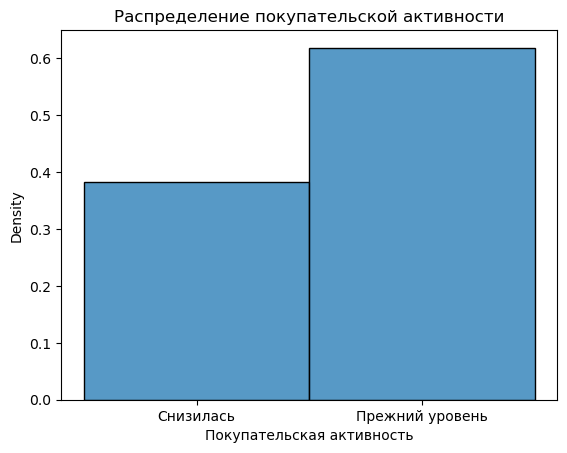

In [33]:
target = 'Покупательская активность'
plt.title('Распределение покупательской активности')
sns.histplot(data=df_market_file, x=target, stat='density')

Дисбаланс у таргета присутствует. Рассмотрим остальные признаки

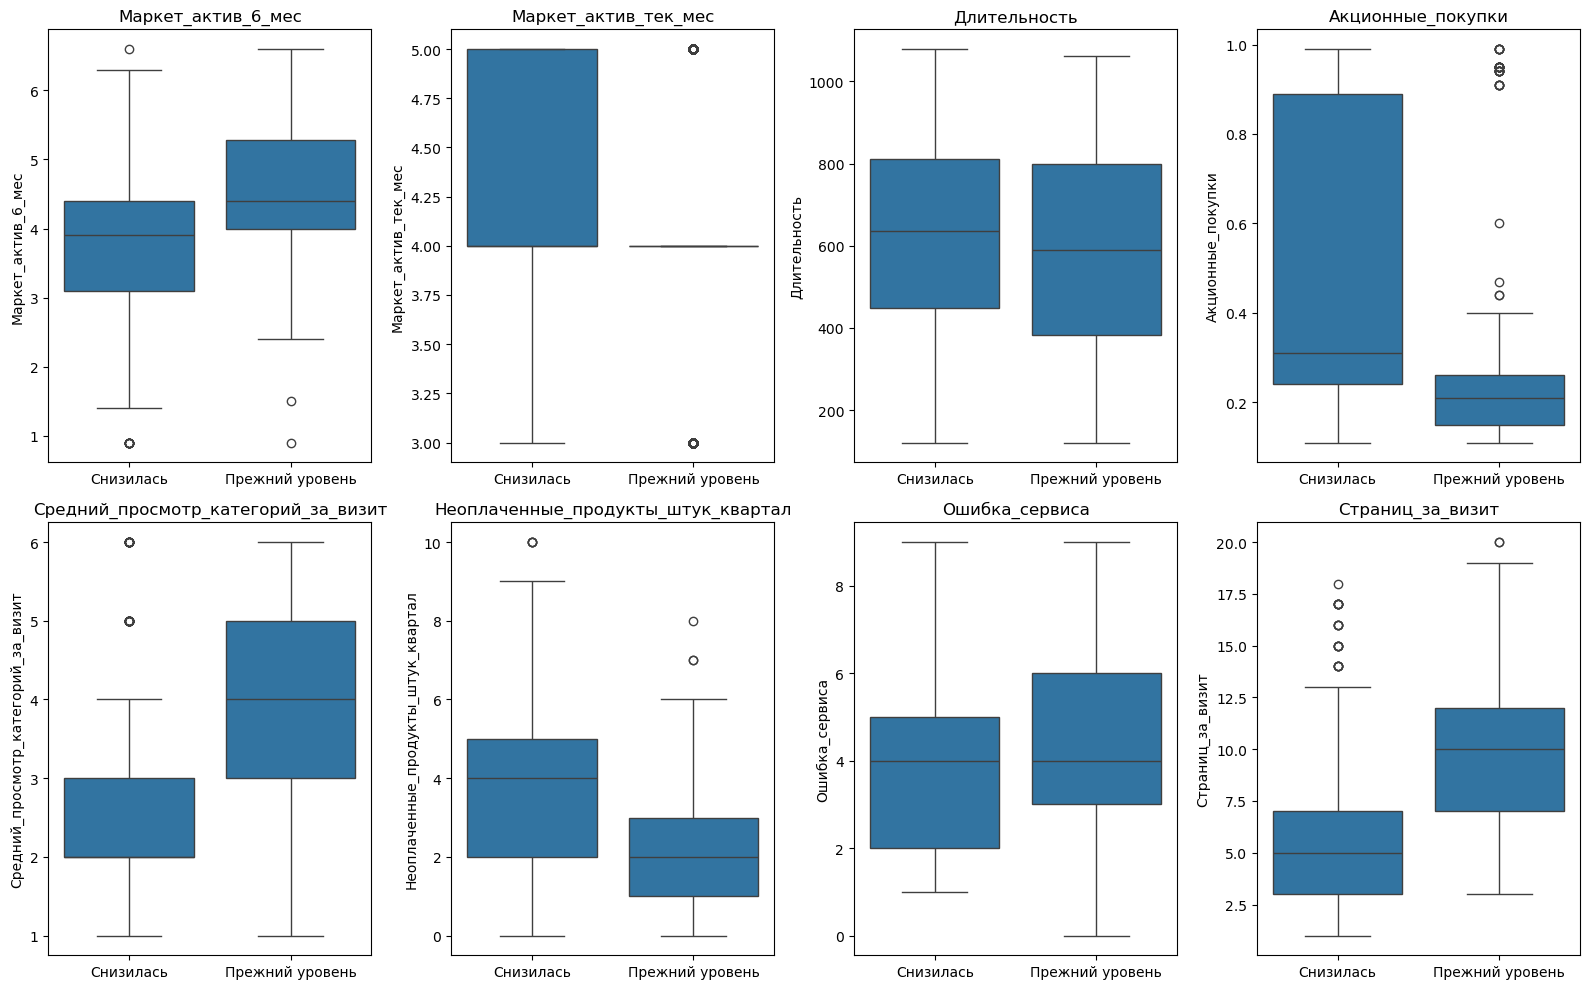

In [34]:
numeric_cols = df_market_file.drop('id', axis=1).select_dtypes(include=['number']).columns

n_cols_per_row = (len(numeric_cols) + 1) // 2

fig, axes = plt.subplots(2, n_cols_per_row, figsize=(4*n_cols_per_row, 10))

axes_flat = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes_flat[i]
    sns.boxplot(data=df_market_file, x=target, y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')


plt.tight_layout()
plt.show()

Покупатели со сниженной активностью получали меньше рекламы за 6 месяцев, однако в этом месяце - гораздо больше чем пользователи которые не снизили свою активность. Помимо этого, пользователи со сниженной активностью в основном делают акционные покупки. Различие групп также сильно наблюдается и во времени, которые пользователи проводят в сервисе - пользователи со сниженной активностью смотрят меньше категорий и страниц за один визит. У пользователей со сниженной активностью также больше неоплаченных товаров за квартал. 

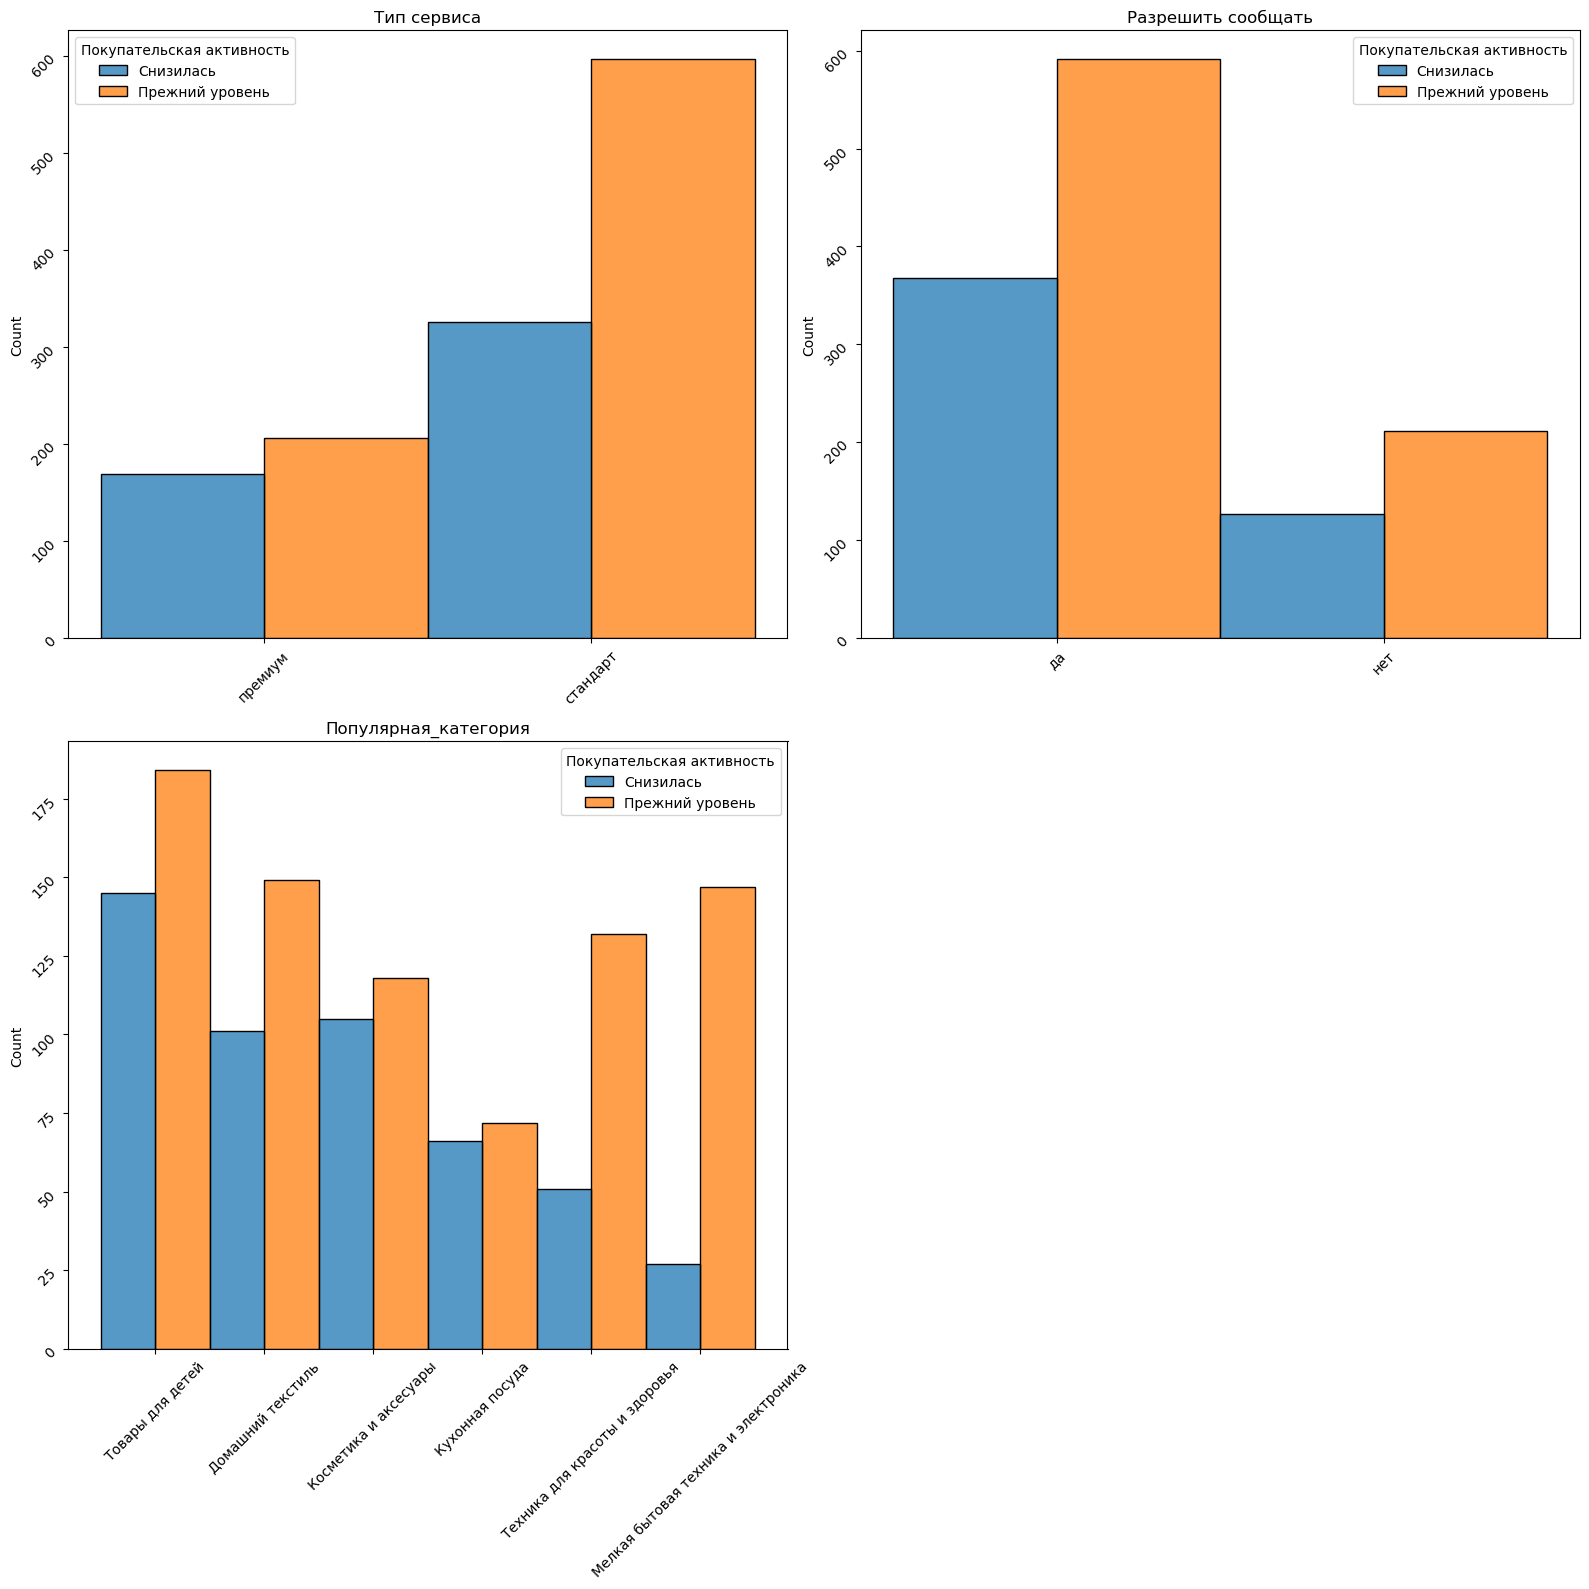

In [35]:
cat_cols = df_market_file.drop(['id', 'Покупательская активность'], axis=1).select_dtypes(exclude=['number']).columns

n_cols_per_row = (len(cat_cols) + 1) // 2

fig, axes = plt.subplots(2, n_cols_per_row, figsize=(8*n_cols_per_row, 16))

axes_flat = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes_flat[i]
    ax.tick_params(labelrotation=45)
    sns.histplot(data=df_market_file, x=col, hue=target, multiple="dodge", ax=ax)
    ax.set_title(col)
    ax.set_xlabel('')

for i in range(len(cat_cols), len(axes_flat)):
    axes_flat[i].set_visible(False)

plt.tight_layout()
plt.show()

Среди категориальных признаков можно отметить что пользователи со сниженной активностью любят пользоваться премиум подпиской

Пользователи со сниженной активностью обладают следующими чертами:
- Низкая активность за одну сессию, смотрит мало категорий и посещает мало страниц
- Ему приходит повышенное количество рекламы
- Очень часто пользуется акциями и скидками на товары

Рассмотрим данные о времени, которое проводят на сервисе двух категорий

<Axes: title={'center': 'Уходящие пользователи'}, xlabel='Период', ylabel='минут'>

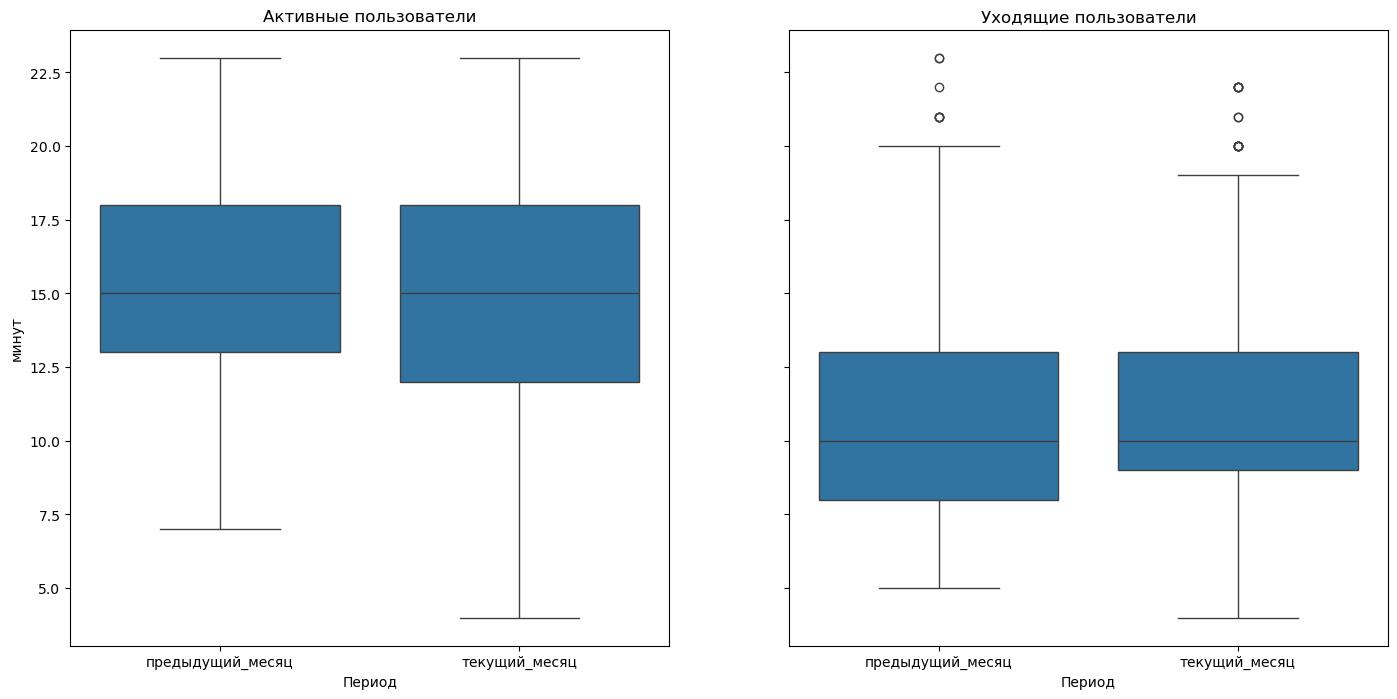

In [36]:
active_ids = df_market_file[df_market_file['Покупательская активность'] != 'Снизилась']['id'].tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8), sharey=True)
ax1.set_title('Активные пользователи')
sns.boxplot(data=df_market_time[df_market_time['id'].isin(active_ids)], x='Период', y='минут',
            order=['предыдущий_месяц', 'текущий_месяц'], ax=ax1)
ax2.set_title('Уходящие пользователи')
sns.boxplot(data=df_market_time[~df_market_time['id'].isin(active_ids)], x='Период', y='минут',
            order=['предыдущий_месяц', 'текущий_месяц'], ax=ax2)

Среднее время в предыдущий и текущий месяцы у уходящих пользователей совпадает. В сравнении с активными пользователями, уходящие проводят на сервисе в среднем меньше времени.

<Axes: ylabel='Выручка'>

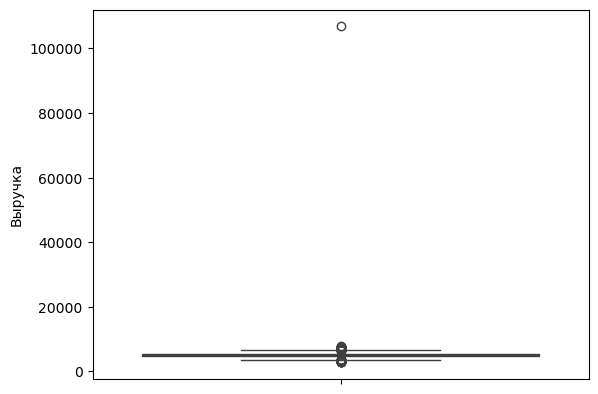

In [37]:
sns.boxplot(data=df_market_money, y='Выручка')

Замечен один пользователь с выручкой > 100000, что является выбросом, его нужно убрать из всех таблиц

In [38]:
anomal_user = df_market_money.query('Выручка > 40000')['id'].tolist()
df_market_file = df_market_file[~df_market_file['id'].isin(anomal_user)]
df_market_time = df_market_time[~df_market_time['id'].isin(anomal_user)]
df_market_money = df_market_money[~df_market_money['id'].isin(anomal_user)]
df_money = df_money[~df_money['id'].isin(anomal_user)]

print(df_market_file.shape, df_market_time.shape, df_market_money.shape, df_money.shape)

(1296, 13) (2592, 3) (3888, 3) (1296, 2)


<Axes: title={'center': 'Уходящие пользователи'}, xlabel='Период', ylabel='Выручка'>

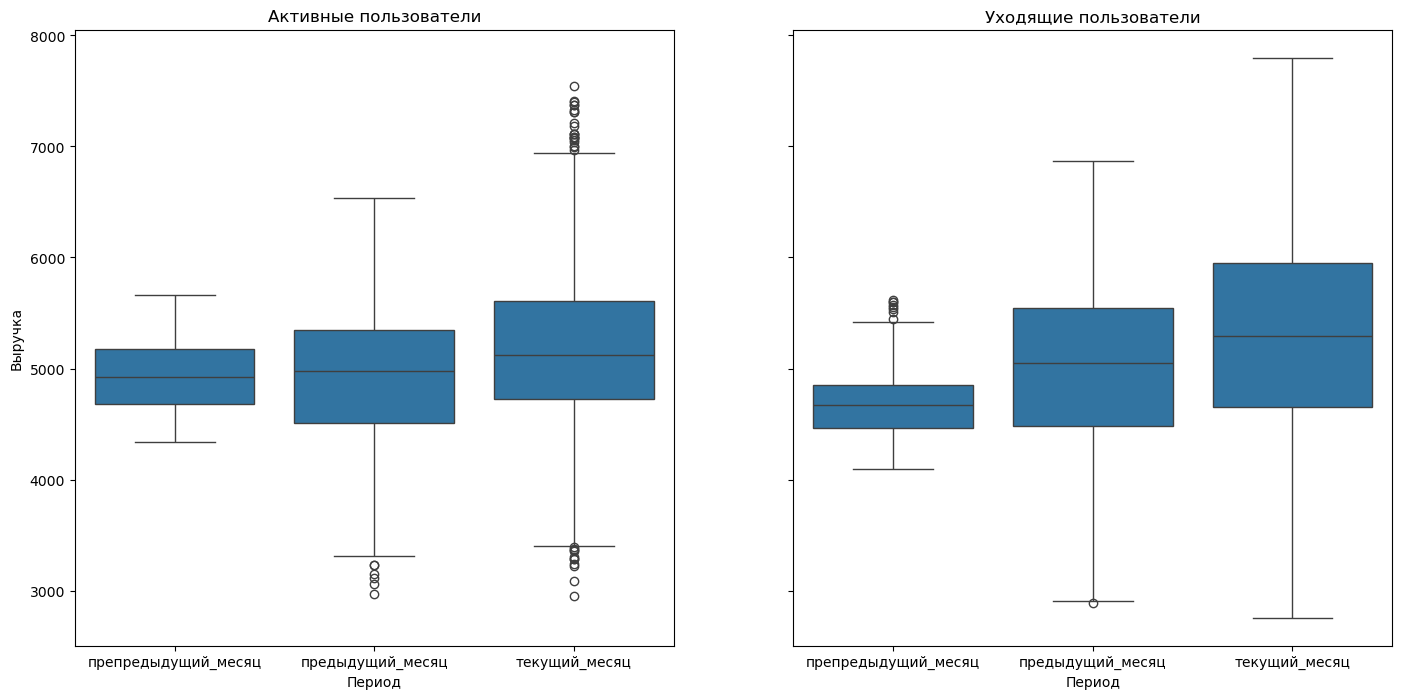

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8), sharey=True)
ax1.set_title('Активные пользователи')
sns.boxplot(data=df_market_money[df_market_money['id'].isin(active_ids)], x='Период', y='Выручка',
            order=['препредыдущий_месяц','предыдущий_месяц', 'текущий_месяц'], ax=ax1)
ax2.set_title('Уходящие пользователи')
sns.boxplot(data=df_market_money[~df_market_money['id'].isin(active_ids)], x='Период', y='Выручка',
            order=['препредыдущий_месяц','предыдущий_месяц', 'текущий_месяц'], ax=ax2)

С уходящий пользователей, на удивление, в текущем месяце получилось больше выручки, чем с активных. С течением времени, средняя выручка с уходящих пользователей росла стремительнее, чем с активных. Задача по удержанию этой категории пользователей стаёт ещё острее.

**Вывод**    
В результате исследовательского анализа данных получен портрет среднего уходящего пользователя.    
Пользователи со сниженной активностью обладают следующими чертами:
- Низкая активность за одну сессию, смотрит мало категорий и посещает мало страниц
- Ему приходит повышенное количество рекламы
- Очень часто пользуется акциями и скидками на товары


## Объединение таблиц

Объединим все таблицы в одну, сохраняя записи о выручке и времени по периодам

In [40]:
# Функция для преобразования таблиц в широкий формат
def pivot_table(df, value_col, prefix):
    """Преобразует таблицу из длинного в широкий формат"""
    pivoted = df.pivot_table(
        index='id',
        columns='Период',
        values=value_col,
        aggfunc='first'  # или 'sum', если у одного пользователя несколько записей за период
    ).reset_index()
    
    # Переименовываем столбцы
    pivoted.columns = ['id'] + [f'{prefix}_{col}' for col in pivoted.columns[1:]]
    
    return pivoted

# Преобразуем таблицу времени
time_pivot = pivot_table(df_market_time, 'минут', 'Время')

# Преобразуем таблицу выручки
revenue_pivot = pivot_table(df_market_money, 'Выручка', 'Выручка')

# Объединяем все таблицы
df = df_market_file.copy()

# Последовательно объединяем с таблицей времени и выручки
df = pd.merge(df, time_pivot, on='id', how='left')
df = pd.merge(df, revenue_pivot, on='id', how='left')

# Заполняем пропущенные значения нулями (если нужно)
df = df.fillna(0)

print("Итоговая таблица:")
df

Итоговая таблица:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Время_предыдущий_месяц,Время_текущий_месяц,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,14,7,3664.0,4704.0,4741.7
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,12,11,4729.0,5299.0,5353.0
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,12,18,5160.0,5334.0,5139.2
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,18,7,4923.0,4725.0,5224.6


**Вывод**    
Размерность итоговой таблицы совпадает с размерностью исходной таблицы market_file, объединение прошло успешно

## Корреляционный анализ

Проведём корреляционный анализ признаков, если будет обнаружены признаки с высокой корреляцией - удалим

In [41]:
def preprocess_data(df):
    df_processed = df.copy()
    
    for column in df_processed.columns:
        if df_processed[column].dtype == 'object':
            # Преобразуем строки в категориальные коды
            df_processed[column] = pd.Categorical(df_processed[column]).codes
    
    return df_processed

# Применяем преобразование
data_processed = preprocess_data(df)
data_processed.drop('id', axis=1, inplace=True)

<Axes: >

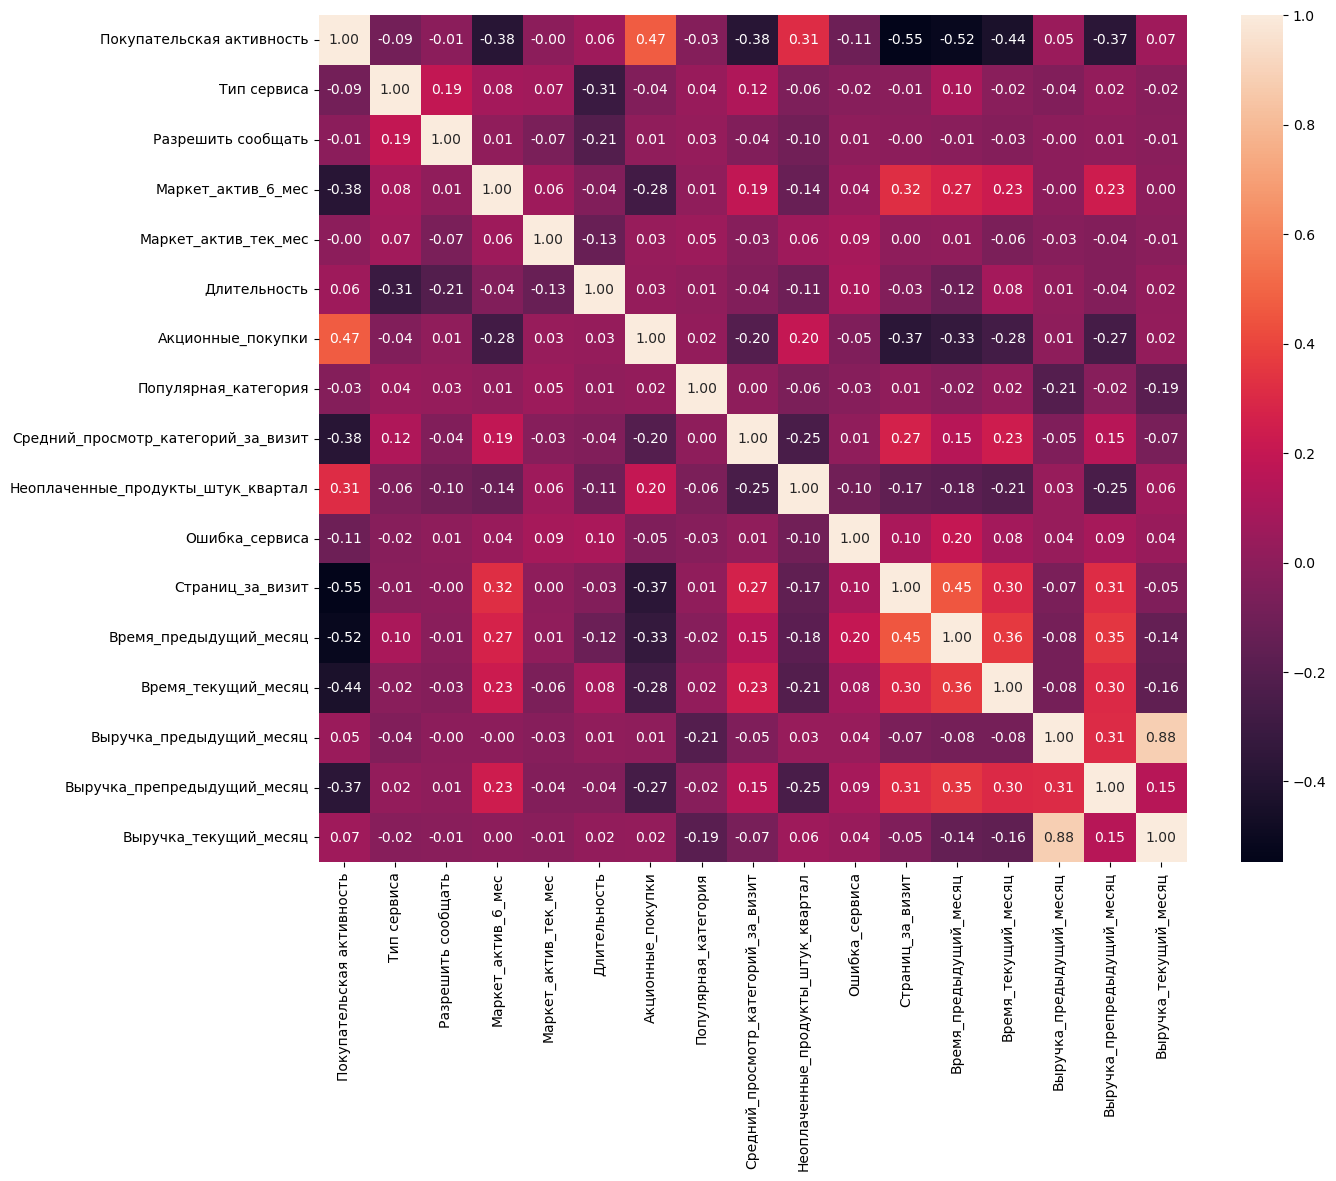

In [42]:
plt.figure(figsize=(14, 11))
sns.heatmap(data_processed.corr(method='spearman'), annot=True, fmt='.2f') 

Мультиколлинеарности не выявлено. Оставим признаки как есть

**Вывод**    
В результате корреляционного анализа признаков мультиколлинеарности не выявлено, признаки оставлены как есть

## Использование пайплайнов

Во время подготовки данных будем использовать ColumnTransformer. Количественные и категориальные признаки обработаем в пайплайне раздельно. Для кодирования категориальных признаков будем использовать OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler.     

В качестве метрики будем использовать roc_auc, так как нам не нужна привязка к порогу классификации. Нам не важно, как хорошо модель ставит метку при определённом пороге, нам важно как с увеличением порога растёт способность модели различать.

In [43]:
RANDOM_STATE=52
TEST_SIZE=0.25

In [44]:
simplefilter(action='ignore', category=FutureWarning)

In [45]:
df = df.set_index('id')

X = df.drop(['Покупательская активность'], axis=1)
y = df['Покупательская активность']

ohe_columns = ['Популярная_категория']
ord_columns = ['Разрешить сообщать', 'Тип сервиса']
num_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [46]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['нет', 'да'],
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [47]:
pipe_knn = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

param_grid_knn = {
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__n_neighbors': range(2, 5),
    }

grid_search_knn = GridSearchCV(
    pipe_knn, 
    param_grid_knn, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_knn.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search_knn.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_knn.best_score_)

Лучшая модель и её параметры: {'models__n_neighbors': 4, 'preprocessor__num': StandardScaler()}
Метрика лучшей модели на тренировочной выборке: 0.8986052788325516


In [48]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        ))
])

param_grid_lr = {
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

grid_search_lr = GridSearchCV(
    pipe_lr, 
    param_grid_lr, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)

print('Лучшая модель и её параметры:', grid_search_lr.best_params_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search_lr.best_score_)

Лучшая модель и её параметры: {'models__C': 1, 'preprocessor__num': MinMaxScaler()}
Метрика лучшей модели на тренировочной выборке: 0.9069486635395727


In [49]:
pipe_svc = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(
            random_state=RANDOM_STATE,
            probability=True
        ))
])

param_grid_svc = {
        'models__C': [0.1, 1, 10],
        'models__kernel': ['rbf', 'poly'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

randomized_search_svc = RandomizedSearchCV(
    pipe_svc, 
    param_grid_svc, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_svc.fit(X_train, y_train)

print('Лучшая модель и её параметры:', randomized_search_svc.best_params_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_svc.best_score_)

Лучшая модель и её параметры: {'preprocessor__num': MinMaxScaler(), 'models__kernel': 'rbf', 'models__C': 0.1}
Метрика лучшей модели на тренировочной выборке: 0.9077633832179286


In [50]:
best_model = randomized_search_svc.best_estimator_

В результате обучения моделей можно выявить лучшую из них:    
- Лучшая модель и её параметры: Логистическая регрессия с гиперпараметрами: C: 0.1, ядро: rbf, с MinMaxScaler
- Метрика лучшей модели на тренировочной выборке: 0.9077633832179286   

Проверим качество на тестовой выборке

In [51]:
y_pred_probas = best_model.predict_proba(X_test)[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, y_pred_probas))

Площадь ROC-кривой: 0.9004838709677419


На тестовой выборке модель показала результат в 0.9004838709677419

## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

Вручную получим названия признаков после подготовки данных в пайплайне

In [ ]:
X_test_prepared = best_model.named_steps['preprocessor'].transform(X_test)
X_train_prepared = best_model.named_steps['preprocessor'].transform(X_train)

sample_size = 500

explainer = shap.SamplingExplainer(
    lambda x: best_model.named_steps['models'].predict_proba(x)[:,1],
    X_test_prepared[:sample_size]
)

shap_values = explainer(X_train_prepared[:sample_size])

explanation = shap.Explanation(
    values=shap_values.values,
    base_values=shap_values.base_values,
    data=X_train_prepared[:sample_size],  # БОЛЬШЕ данных
    feature_names=best_model[:-1].get_feature_names_out()
)

shap.plots.beeswarm(explanation, max_display=20)

  0%|          | 0/500 [00:00<?, ?it/s]

**Вывод**    
Из анализа важности признаков можно подчерпнуть следующий инсайд:    
Действительно, инсайды из исследовательского анализа данных подтверждаются - уходящие покупатели - пользователи, которые смотрят мало страниц за один визит (в целом проводят мало времени на сервисе), покупают в основном товары по акции и обладают премиум подпиской. Вполне вероятно, что пользователи добавляют в корзину желаемый товар и ждут на него акции/скидки (скорее всего, ещё и уведомление об этом приходит). Дополнительно это подтверждается тем, что такие пользователи дали согласие на рассылку доп. предложений о товарах. Решением будет повысить значение маркетинговых коммуникаций компании, которое приходится на таких покупателей (больше звонков, рассылок, рекламы для таких пользователей)

## Сегментация покупателей 

Произведём сегментацию покупателей. Для этого добавим в наш датафрейм с выручкой вероятности снижения покупательской активности

In [ ]:
df_money.set_index('id', inplace=True)
df_money['Риск_снижения_активности'] = best_model.predict_proba(X)[:, 1]
df_money.head()

Выгоднее всего удерживать пользователей, которые приносят нам хорошую выручку. Сегментировать будем по выручке и риску потери пользователей. Дополнительно мы введём подсветку пользователей с зависимостью от акционных покупок. Порог возьмём из исследователького анализа данных

In [ ]:
plt.figure(figsize=(16, 11))
sns.scatterplot(data=df_money, y='Риск_снижения_активности', x='Прибыль')

Рассмотрим данные о прибыли, полученной с пользователей

In [ ]:
sns.boxplot(data=df_money, x='Прибыль')

In [ ]:
df_money['Прибыль'].describe()

Логично будет удерживать пользователей с относительно высокой выручкой (>50%) и высокой вероятностью ухода (>85%). На графике выше заметно большое скопление пользователей с высокой вероятностью оттока, однако всех их удерживать может оказаться финансово нецелесообразно. Попилим эту категорию по медиане прибыли и выберем большую половину. Отберём таких пользователей и произведём анализ этой категории.

In [ ]:
df_money['Прибыль'].head()

In [ ]:
targeted_user_ids = df_money.query('Прибыль > 3.3 & Риск_снижения_активности > 0.85').index.tolist()

In [ ]:
df_targeted = df.loc[df.index.isin(targeted_user_ids)]
df_targeted.head()

In [ ]:
df_other = df.loc[~df.index.isin(targeted_user_ids)]
df_other.head()

In [ ]:
df_targeted.info()

Рассмотрим тип сервиса у таких пользователей

In [ ]:
def comparative_plots(x):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))
    ax1.set_title('Выбранный сегмент')
    ax1.tick_params(axis='x', rotation=45)
    sns.histplot(x=x, data=df_targeted, ax=ax1, stat='density')
    ax2.set_title('Остальные пользователи')
    ax2.tick_params(axis='x', rotation=45)
    sns.histplot(x=x, data=df_other, ax=ax2, stat='density')
    plt.tight_layout()

In [ ]:
comparative_plots('Тип сервиса')

Доля премиум подписчиков в выбранном сегменте больше, но отток всё равно максимальный - странно

Рассмотрим как распределены акционные покупки у нашего сегмента

In [ ]:
comparative_plots('Акционные_покупки')

Как и ожидалось, наши пользователи чаще прибегают к акционным покупкам

Посмотрим распределение категорий

In [ ]:
comparative_plots('Популярная_категория')

Распределение категорий отличается, самый актуальная категория у нашего сегмента - товары для детей (как и у остальных пользователей), однако мелкая бытовая техника и электроника вообще не просматривается, как и техника для красоты и здоровья. Вполне вероятно, что пользователи уже купили всю необходимую технику по акциям и получают неправильные рекомендации. Нужно разобраться, насколько много с ними контактирует маркет

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
ax1.set_title('Выбранный сегмент')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(x='Маркет_актив_тек_мес', data=df_targeted, ax=ax1)
ax2.set_title('Остальные пользователи')
ax2.tick_params(axis='x', rotation=45)
sns.boxplot(x='Маркет_актив_тек_мес', data=df_other, ax=ax2)
plt.tight_layout()

В этом месяце с пользователями из выбранного сегмента контактируют больше чем с остальными, посмотрим на ситтуацию в прошлом. 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
ax1.set_title('Выбранный сегмент')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(x='Маркет_актив_6_мес', data=df_targeted, ax=ax1)
ax2.set_title('Остальные пользователи')
ax2.tick_params(axis='x', rotation=45)
sns.boxplot(x='Маркет_актив_6_мес', data=df_other, ax=ax2)
plt.tight_layout()

Однако в за прошедшие месяцы актива в сторону пользователей было меньше, что не сказать про остальных пользователей

In [ ]:
sns.histplot(data=df_targeted, x='Разрешить сообщать')

Посмотрим на выручку по месяцам у нашего сегмента

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))
ax1.set_title('Выбранный сегмент')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(data=df_market_money[df_market_money['id'].isin(targeted_user_ids)], x='Период', y='Выручка',
            order=['препредыдущий_месяц','предыдущий_месяц', 'текущий_месяц'], ax=ax1)
ax2.set_title('Остальные пользователи')
ax2.tick_params(axis='x', rotation=45)
sns.boxplot(data=df_market_money[~df_market_money['id'].isin(targeted_user_ids)], x='Период', y='Выручка',
            order=['препредыдущий_месяц','предыдущий_месяц', 'текущий_месяц'], ax=ax2)
plt.tight_layout()

Однако выручка пользователей из выбранного сегмента растёт с каждым месяцем.

А не может ли ошибки сервиса влиять на активность?

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
ax1.set_title('Выбранный сегмент')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(x='Ошибка_сервиса', data=df_targeted, ax=ax1)
ax2.set_title('Остальные пользователи')
ax2.tick_params(axis='x', rotation=45)
sns.boxplot(x='Ошибка_сервиса', data=df_other, ax=ax2)
plt.tight_layout()

Ошибок в выбранном сегменте в среднем гораздо меньше. Дело не в этом

В заключение, осмотрим количество неоплаченных товаров у пользователей

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))
ax1.set_title('Выбранный сегмент')
ax1.tick_params(axis='x', rotation=45)
sns.boxplot(x='Неоплаченные_продукты_штук_квартал', data=df_targeted, ax=ax1)
ax2.set_title('Остальные пользователи')
ax2.tick_params(axis='x', rotation=45)
sns.boxplot(x='Неоплаченные_продукты_штук_квартал', data=df_other, ax=ax2)
plt.tight_layout()

У выбранного сегмента больше неоплаченных товаров в корзине. Анализ окончен - можно приступать к выводам

**Вывод**     
Из проведённого анализа можно сделать вывод, что покупатели из выбранного сегмента (выручка выше среднего, высокий риск потери) - пришли в сервис из-за акций. Вполне верятно их завлекли болшими скидками с премиум подпиской (объясняет высокое количество пользователей с премиумом среди уходящих пользователей). Среди уходящих пользователей не популярны категории электроники, хотя у других пользователей это не так - значит они их уже купили и покупать более не планируют (что логично, это одноразовые покупки). Также, у этой группы больше неоплаченных товаров в корзине, что может быть в виду двух причин: они добавляют в корзину товары в надежде что на них будет акция или на них уже есть акция, они хотят его купить но акция заканчивается, что может раздражать пользователей, из-за этого и отток     

В итоге - перед нами пользователи, привлечённые акциями (может быть с участием премиума), зачастую с премиум подпиской, которые совершают много акционных покупок. Имея портрет таких пользователей - можно сделать следующие рекомендации:
 - Удерживаем таких пользователей с помощью акций, однако их нужно персонализировать, на основе их корзины/популярной среди пользователя категории
 - С целевыми пользователями за последние 6 месяцев контактировали меньше чем в текущем месяце. Возможно стоит оставить частоту звонков/рассылок на прежнем уровне. Излишнее навязывание услуг может отпугивать пользователей

## Общий вывод

**Задача проекта**:    
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Результаты предобработки данных**:
- Пропуски не обнаружены
- Удалены неявные дупликаты в столбце "Тип сервиса" в таблице с основными данными
- Удалены неявные дупликаты в столбце "Период" в таблице с данными о проведённом пользователями времени
- Исправлен тип данных у столбца "Прибыль" в таблице с данными о выручке

**Поиск лучшей модели**:    
Были обучены 4 модели, из них LogisticRegression, SVC, DecisionTreeClassifier, KNeighborsClassifier. Для обучения использовались пайплайны для предобработки данных и подбору гиперпараметров. Гиперпараметры для всех классификаторов, кроме SVC перебирались GridSearch'ем, для SVC был выбран RandomizedSearch для оптимизации. В качестве метрики был выбран roc_auc.

По итогам обучения, была выявлена лучшая модель - метод опорных векторов с RBF ядром с гиперпараметром С - 1.

**Сегментация покупателей**:    
Сегментация была произведена на основе риска потери клиента и его выручке. В исследуемый сегмент были отобраны пользователи с выручкой выше среднего и очень высоким риском оттока. Для этого сегмента был проведён сравнительный анализ относительно других пользователей с визуализацией. По итогу были разработаны следующие предложения:
 - Удерживаем таких пользователей с помощью акций, однако их нужно персонализировать, на основе их корзины/популярной среди пользователя категории
 - С целевыми пользователями за последние 6 месяцев контактировали меньше чем в текущем месяце. Возможно стоит оставить частоту звонков/рассылок на прежнем уровне. Излишнее навязывание услуг может отпугивать пользователей